## EDA of 2018 data science bowl stage1 train data, notebook adapts from this [kernel](https://www.kaggle.com/jackvial/exploratory-data-analysis-dsb-2018)

In [0]:
# Get stage1 train/test data
%%capture
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test
!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

SEED = 42
np.random.seed(SEED)

# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'
# TEST_PATH = 'stage2_test_final/'

Using TensorFlow backend.


In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print("train size:", len(train_ids))
print("test size:", len(test_ids))


train size: 670
test size: 65


In [19]:
# store imgs and masks
imgs = [] 
masks = []

# store meta data of the training img
img_data = []
mask_data = []

print('Processing images ... ')
# Progress bar
a = Progbar(len(train_ids))
# Loop over the training images
for n, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    # Get image and image size.
    imgs.append(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_depth = img.shape[2]
    img_area = img_width * img_height

    # Count the number of nucleus in each image.
    nucleus_count = 0
    nucleus_area = 0
    mask_combined = np.zeros((img_height, img_width))
    # Loop over the mask ids, read the images and gather metadata from them.
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask = imread(path + '/masks/' + mask_file)
        # Combine the mask images
        mask_combined += mask
        # Sum and divide by 255 to get the number
        # of pixels for the nucleus. Masks are grayscale.
        nucleus_area += (np.sum(mask) / 255)
        # Increment nucleus count.
        nucleus_count = nucleus_count + 1
    # mask_to_img_ratio = nucleus_area / mask_area
    mask_to_img_ratio = nucleus_area / img_area
    masks.append(mask_combined)
    # Append meta data to list and will be used to create a pandas dataframe
    mask_data.append([nucleus_area, img_area, mask_to_img_ratio])
    img_data.append([img.shape, img_area, nucleus_count])
    a.update(n)

Processing images ... 
669/670 [============================>.] - ETA: 0s

In [0]:
# transfrom to dataframe to analyze easily
df_img = pd.DataFrame(img_data, columns=['img_shape', 'img_area', 'nuclei_count'])

### Image shape distribution

In [23]:
df_img['img_shape'].value_counts()

(256, 256, 4)      334
(256, 320, 4)      112
(520, 696, 4)       92
(360, 360, 4)       91
(1024, 1024, 4)     16
(512, 640, 4)       13
(603, 1272, 4)       6
(260, 347, 4)        5
(1040, 1388, 4)      1
Name: img_shape, dtype: int64

### Image area and corresponding nuclei count

In [24]:
df_img.describe()

,img_area,nuclei_count
count,6.700000e+02,670.000000
mean,1.547583e+05,43.971642
std,1.908250e+05,47.962530
min,6.553600e+04,1.000000
25%,6.553600e+04,15.250000
50%,8.192000e+04,27.000000
75%,1.296000e+05,54.000000
max,1.443520e+06,375.000000


Text(0.5,1,'counts of nuclei number')

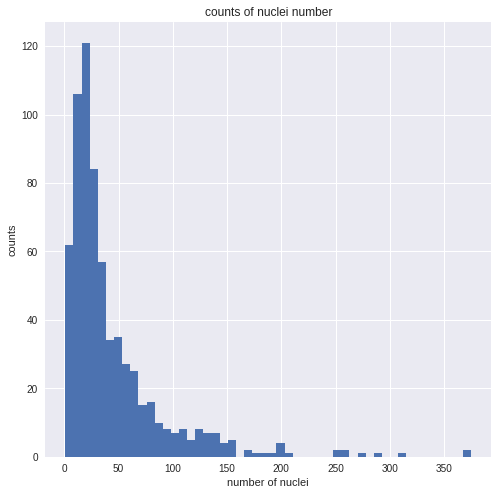

In [44]:
plt.figure(figsize=(8,8))
plt.hist(df_img['nuclei_count'], bins=50)
plt.xlabel('number of nuclei')
plt.ylabel('counts')
plt.title('counts of nuclei number')

Text(0,0.5,'nuclei count')

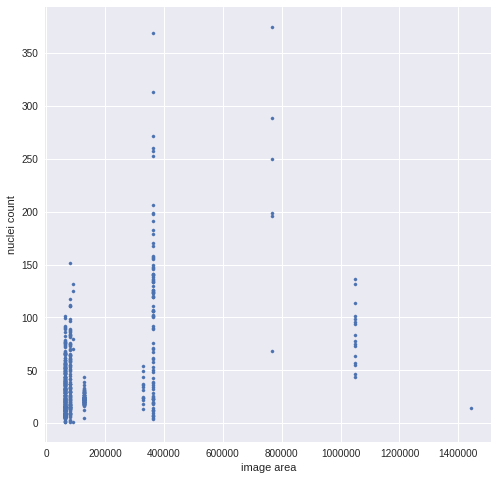

In [45]:
plt.figure(figsize=(8,8))
plt.scatter(df_img['img_area'].values, df_img['nuclei_count'].values, s=10)
plt.xlabel('image area')
plt.ylabel('nuclei count')

### Images with max number of nucleus

nuclei count: 375
maximum count nuclei images id a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288


Text(0.5,1,'masks')

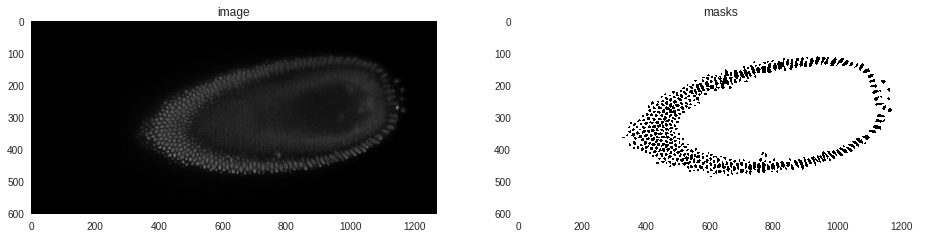

In [79]:
idx = df_img['nuclei_count'].idxmax()
print("nuclei count:", df_img['nuclei_count'][idx])
print("maximum count nuclei images id", train_ids[idx])

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.grid(None)
plt.imshow(imgs[idx])
plt.title('image')

plt.subplot(122)
plt.grid(None)
plt.imshow(masks[idx])
plt.title('masks')

### Images with min number of nucleus

nuclei count: 1
minimum count nuclei images id 93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77


Text(0.5,1,'masks')

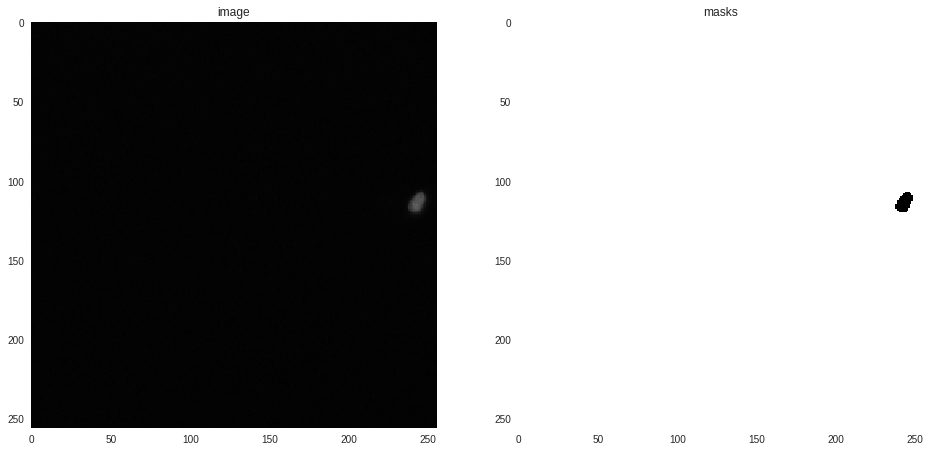

In [80]:
idx = df_img['nuclei_count'].idxmin()
print("nuclei count:", df_img['nuclei_count'][idx])
print("minimum count nuclei images id", train_ids[idx])

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.grid(None)
plt.imshow(imgs[idx])
plt.title('image')

plt.subplot(122)
plt.grid(None)
plt.imshow(masks[idx])
plt.title('masks')

### Check the ratio of nuclei pixel area to image pixel area

In [0]:
df_mask = pd.DataFrame(mask_data, columns=['nucleus_area', 'img_area', 'mask_to_img_ratio'])

maximum mask to image ratio: 0.59202880859375
Image id: 13f2bec0a24c70345372febb14c4352877b1b6c1b01896246048e83c345c0914


Text(0.5,1,'masks')

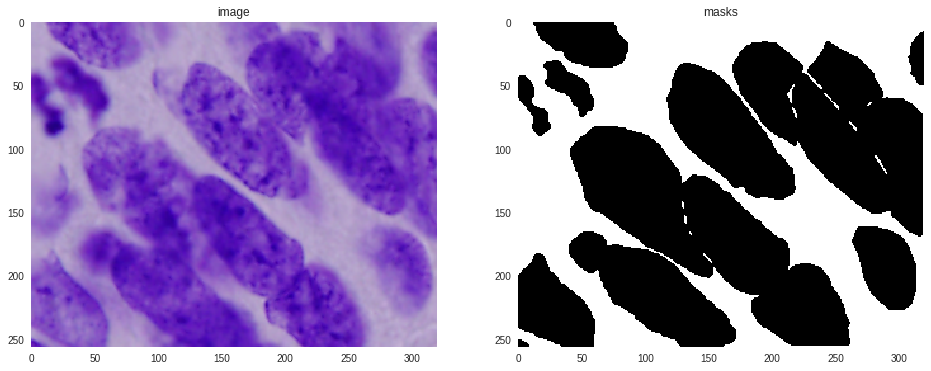

In [81]:
idx = df_mask['mask_to_img_ratio'].idxmax()
print("maximum mask to image ratio:", df_mask['mask_to_img_ratio'][idx])
print("Image id:", train_ids[idx])
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.grid(None)
plt.imshow(imgs[idx])
plt.title('image')

plt.subplot(122)
plt.grid(None)
plt.imshow(masks[idx])
plt.title('masks')

minimum mask to image ratio: 0.00028818443804034583
Image id: 7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80


Text(0.5,1,'masks')

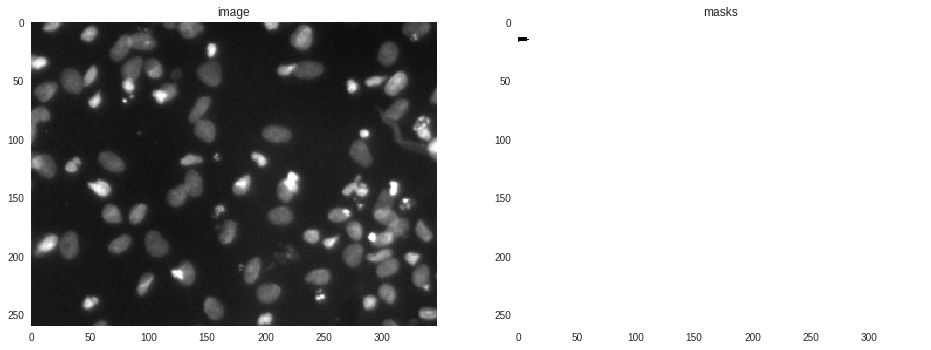

In [82]:
idx = df_mask['mask_to_img_ratio'].idxmin()
print("minimum mask to image ratio:", df_mask['mask_to_img_ratio'][idx])
print("Image id:", train_ids[idx])
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.grid(None)
plt.imshow(imgs[idx])
plt.title('image')

plt.subplot(122)
plt.grid(None)
plt.imshow(masks[idx])
plt.title('masks')

In [46]:
df_mask.describe()

,nucleus_area,img_area,mask_to_img_ratio
count,670.000000,6.700000e+02,670.000000
mean,20745.983582,1.547583e+05,0.139191
std,24197.742276,1.908250e+05,0.110723
min,26.000000,6.553600e+04,0.000288
25%,2692.000000,6.553600e+04,0.034058
50%,11117.500000,8.192000e+04,0.106728
75%,31723.750000,1.296000e+05,0.233740
max,122721.000000,1.443520e+06,0.592029


### Randomly shows images and corresponding masks

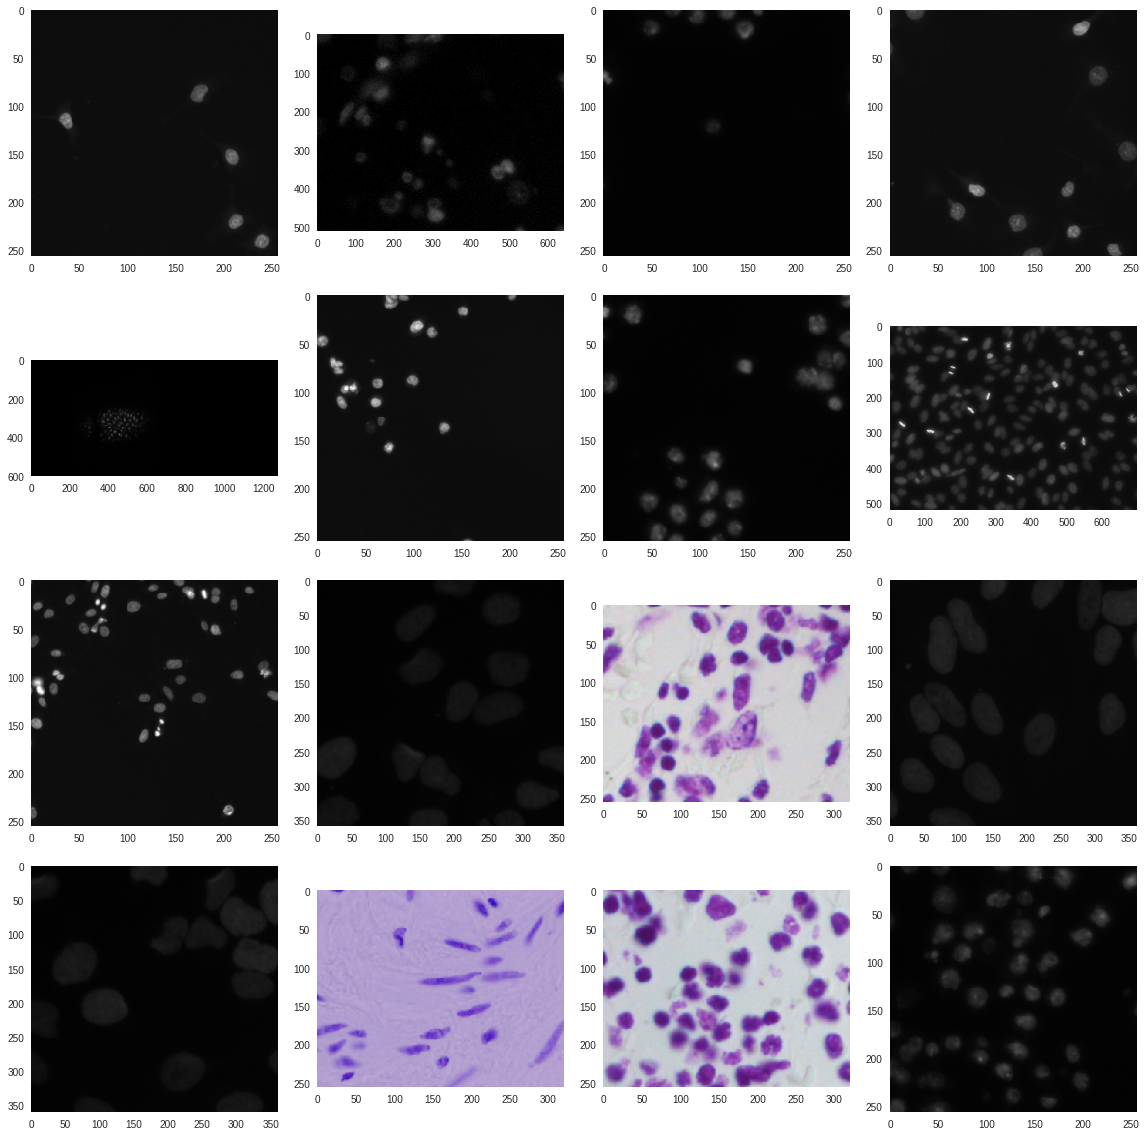

In [83]:
sample_nuclei = df_img.sample(16).index
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
row = 0
col = 0
for i, img_id in enumerate(sample_nuclei):
    ax[row, col].grid(False)
    ax[row, col].imshow(imgs[img_id])
    
    # Increment col index and reset each time
    # it gets to 4 to start a new row
    col = col + 1
    if(col == 4):
        col = 0
    
    # Increment row index every 4 items
    if((i + 1) % 4 == 0):
        row = row + 1
plt.tight_layout()

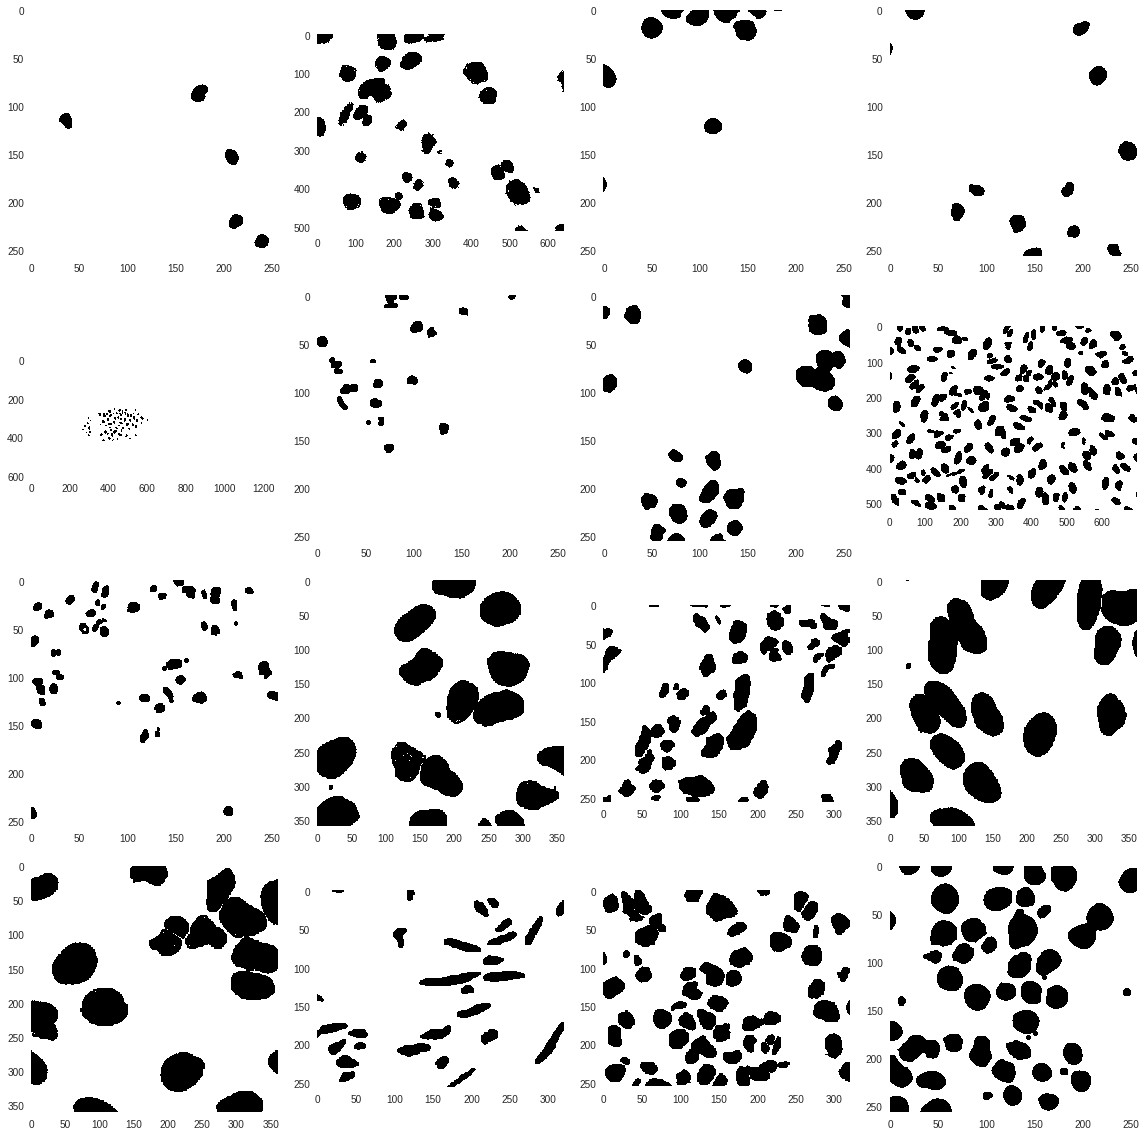

In [84]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
row = 0
col = 0
for i, img_id in enumerate(sample_nuclei):
    ax[row, col].grid(False)
    ax[row, col].imshow(masks[img_id])
    
    # Increment col index and reset each time
    # it gets to 4 to start a new row
    col = col + 1
    if(col == 4):
        col = 0
    
    # Increment row index every 4 items
    if((i + 1) % 4 == 0):
        row = row + 1
plt.tight_layout()

### Stage 1 test data

In [7]:
# store imgs and masks
imgs = [] 

# store meta data of the training img
img_data = []

print('Processing images ... ')
# Progress bar
a = Progbar(len(test_ids))
# Loop over the training images
for n, id_ in enumerate(test_ids):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    # Get image and image size.
    imgs.append(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_depth = img.shape[2]
    img_area = img_width * img_height
    img_data.append([img.shape, img_area])
    a.update(n)

Processing images ... 
62/65 [===========================>..] - ETA: 0s

In [0]:
# transfrom to dataframe to analyze easily
df_img = pd.DataFrame(img_data, columns=['img_shape', 'img_area'])

In [10]:
df_img['img_shape'].value_counts()

(256, 256, 4)    20
(512, 640, 4)     8
(512, 680, 3)     8
(256, 256, 3)     4
(519, 253, 3)     4
(520, 348, 3)     4
(260, 347, 4)     4
(520, 696, 4)     4
(524, 348, 3)     4
(519, 161, 3)     2
(519, 162, 3)     2
(390, 239, 4)     1
Name: img_shape, dtype: int64

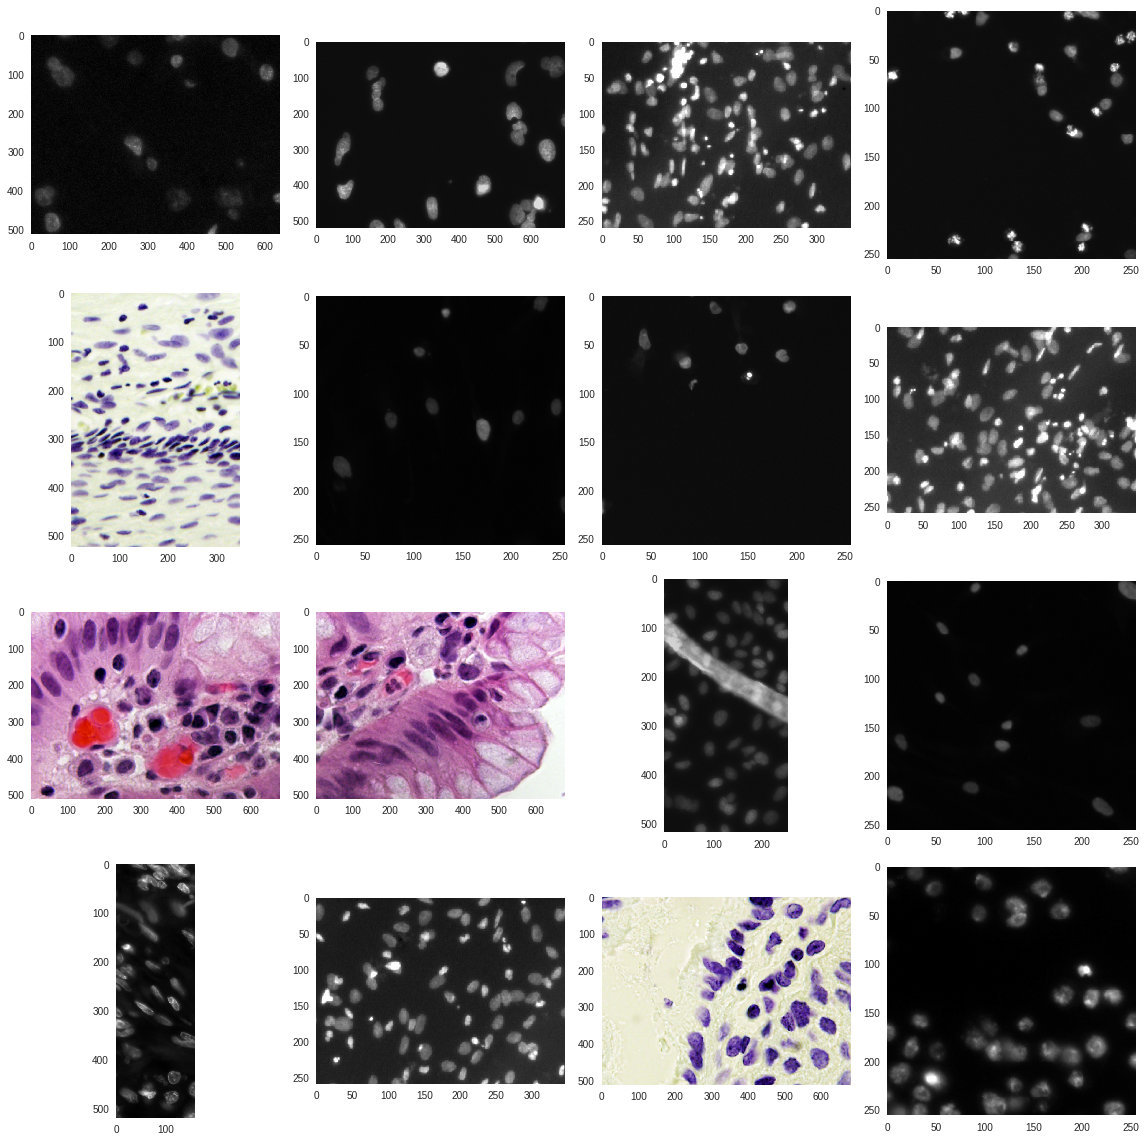

In [9]:
sample_nuclei = df_img.sample(16).index
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
row = 0
col = 0
for i, img_id in enumerate(sample_nuclei):
    ax[row, col].grid(False)
    ax[row, col].imshow(imgs[img_id])
    
    # Increment col index and reset each time
    # it gets to 4 to start a new row
    col = col + 1
    if(col == 4):
        col = 0
    
    # Increment row index every 4 items
    if((i + 1) % 4 == 0):
        row = row + 1
plt.tight_layout()

### Conlusion 
I am writing it in my report.